In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import re
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# PATHS

dataset_path = "/content/drive/MyDrive/Slake/Slake1.0"
checkpoint_dir = "/content/drive/MyDrive/CNN_LSTM_C3"
os.makedirs(checkpoint_dir, exist_ok=True)

train_json = os.path.join(dataset_path, "train.json")
val_json = os.path.join(dataset_path, "validate.json")
test_json = os.path.join(dataset_path, "test.json")
images_folder = os.path.join(dataset_path, "imgs")

In [4]:
# DATA PREPROCESSING

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
#Filter to English-only questions
def filter_english_only(data):
    """Filter to keep only English questions (q_lang == 'en')"""
    english_data = [item for item in data if item.get('q_lang') == 'en']
    print(f"  Original: {len(data)} samples")
    print(f"  English only: {len(english_data)} samples")
    return english_data

# Load data
with open(train_json, "r") as f:
    train_data_raw = json.load(f)
with open(val_json, "r") as f:
    val_data_raw = json.load(f)
with open(test_json, "r") as f:
    test_data_raw = json.load(f)

print("="*60)
print("FILTERING TO ENGLISH QUESTIONS")
print("="*60)
print("Train:")
train_data = filter_english_only(train_data_raw)
print("Validation:")
val_data = filter_english_only(val_data_raw)
print("Test:")
test_data = filter_english_only(test_data_raw)

FILTERING TO ENGLISH QUESTIONS
Train:
  Original: 9835 samples
  English only: 4919 samples
Validation:
  Original: 2099 samples
  English only: 1053 samples
Test:
  Original: 2094 samples
  English only: 1061 samples


In [6]:
# Build answer vocabulary



print("\n" + "="*60)
print("BUILDING ANSWER VOCABULARY")
print("="*60)

# Count all answers from English training data
all_answers = [sample["answer"] for sample in train_data]
answer_counter = Counter(all_answers)


print(f"Total training samples: {len(all_answers)}")
print(f"Total unique answers: {len(answer_counter)}")


# Get unique answers and sort for consistency
unique_answers = sorted(list(answer_counter.keys()))

# Build mapping
answer_to_index = {ans: idx for idx, ans in enumerate(unique_answers)}

# Add <unk> token for rare/unseen answers
#UNK_ANSWER = "<unk>"
#answer_to_index[UNK_ANSWER] = len(answer_to_index)

index_to_answer = {idx: ans for ans, idx in answer_to_index.items()}
NUM_CLASSES = len(answer_to_index)

print(f"Final answer classes : {NUM_CLASSES}")



BUILDING ANSWER VOCABULARY
Total training samples: 4919
Total unique answers: 228
Final answer classes : 228


In [7]:
# Filter datasets to only include vocabulary answers
def filter_by_vocabulary(data, answer_to_index):
    filtered = []
    skipped = 0

    for item in data:
        if item["answer"] in answer_to_index:
            filtered.append(item)
        else:
            skipped += 1

    print(f"  Samples: {len(filtered)}, Skipped: {skipped}")
    return filtered

print("\n" + "="*60)
print("FILTERING DATASETS")
print("="*60)

print("Train:")
train_data = filter_by_vocabulary(train_data, answer_to_index)

print("Val:")
val_data = filter_by_vocabulary(val_data, answer_to_index)

print("Test:")
test_data = filter_by_vocabulary(test_data, answer_to_index)



FILTERING DATASETS
Train:
  Samples: 4919, Skipped: 0
Val:
  Samples: 1048, Skipped: 5
Test:
  Samples: 1059, Skipped: 2


In [8]:
# Build question vocabulary

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9 ]", "", text)  # English only
    return text.split()

# Count words from training questions
word_counter = Counter()
for sample in train_data:
    tokens = tokenize(sample["question"])
    word_counter.update(tokens)

# Keep top 3000 words
MAX_VOCAB = 3000
most_common_words = word_counter.most_common(MAX_VOCAB)

# Build mapping
word_to_index = {word: idx+1 for idx, (word, _) in enumerate(most_common_words)}
word_to_index["<pad>"] = 0
word_to_index["<unk>"] = len(word_to_index)
VOCAB_SIZE = len(word_to_index)
print(f"\nQuestion vocabulary size: {VOCAB_SIZE}")



Question vocabulary size: 292


In [9]:
# Encode question

MAX_QUESTION_LEN = 20

def encode_question(question):
    tokens = tokenize(question)
    indices = [word_to_index.get(token, word_to_index["<unk>"]) for token in tokens[:MAX_QUESTION_LEN]]
    while len(indices) < MAX_QUESTION_LEN:
        indices.append(word_to_index["<pad>"])
    return torch.tensor(indices)


In [10]:
# Dataset class

class SLAKEDataset(Dataset):
    def __init__(self, data_list, images_folder, transform=None):
        self.data = data_list
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Load image
        image_path = os.path.join(self.images_folder, sample["img_name"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Encode question
        question_text = sample["question"]
        question_encoded = encode_question(question_text)

        # Encode answer
        answer_text = sample["answer"]
        answer_label = answer_to_index[answer_text]#, answer_to_index["<unk>"])

        # Get question type
        answer_type = sample.get("answer_type", "UNKNOWN")

        return image, question_encoded, torch.tensor(answer_label), question_text, answer_type


In [11]:
# Create datasets and dataloaders

train_dataset = SLAKEDataset(train_data, images_folder, transform=transform)
val_dataset = SLAKEDataset(val_data, images_folder, transform=transform)
test_dataset = SLAKEDataset(test_data, images_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")




Dataset sizes:
  Train: 4919
  Val: 1048
  Test: 1059


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN_LSTM_MedVQA(nn.Module):
    def __init__(self, vocab_size, embed_size=128, num_classes=229, dropout=0.3):
        super().__init__()

        # =====================
        # Image Encoder
        # =====================
        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        #  Freeze early layers, unfreeze last block for fine-tuning
        for param in self.cnn[:-2].parameters():  # Freeze except last 2 blocks
            param.requires_grad = False

        # Project to 512
        self.cnn_fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # =====================
        # Question Encoder
        # =====================
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Deeper LSTM with more capacity
        self.lstm = nn.LSTM(
            embed_size,
            256,  # 256 * 2 (bidirectional) = 512 to match CLIP
            num_layers=2,  # ← Increased from 1 to 2 layers
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Additional processing for LSTM output
        self.lstm_fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # =====================
        # Fusion Network
        # =====================

        self.fusion = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout * 0.7),  # Slightly less dropout
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU()
        )

        # =====================
        # Classifier
        # =====================
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, images, questions):
        # ---- Image ----
        img_feat = self.cnn(images)
        img_feat = img_feat.view(img_feat.size(0), -1)
        img_feat = self.cnn_fc(img_feat)  # [B, 512]

        # ---- Question ----
        emb = self.embedding(questions)
        lstm_out, (hidden, _) = self.lstm(emb)

        # Concatenate last forward & backward from final layer
        ques_feat = torch.cat([hidden[-2], hidden[-1]], dim=1)  # [B, 512]
        ques_feat = self.lstm_fc(ques_feat)  # [B, 512]

        # ---- Fusion ----
        fused = torch.cat([img_feat, ques_feat], dim=1)  # [B, 1024]
        fused = self.fusion(fused)  # [B, 512]

        return self.classifier(fused)  # [B, num_classes]

In [13]:
# ===============================
# MODEL SETUP
# ===============================
model = CNN_LSTM_MedVQA(
    vocab_size=VOCAB_SIZE,
    embed_size=128,
    num_classes=NUM_CLASSES,
    dropout=0.3
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


MODEL SUMMARY
Total parameters: 16,066,852
Trainable parameters: 13,284,068
Frozen parameters: 2,782,784


In [14]:
# Evaluation functions with F1 by question type

def evaluate(model, loader, device):
    #Calculate accuracy and F1 scores
    model.eval()

    all_preds = []
    all_labels = []
    open_preds = []
    open_labels = []
    closed_preds = []
    closed_labels = []

    with torch.no_grad():
        for images, questions, answers, _, answer_types in loader:
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            outputs = model(images, questions)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(answers)):
                pred = preds[i].item()
                label = answers[i].item()

                all_preds.append(pred)
                all_labels.append(label)

                if answer_types[i] == "OPEN":
                    open_preds.append(pred)
                    open_labels.append(label)
                elif answer_types[i] == "CLOSED":
                    closed_preds.append(pred)
                    closed_labels.append(label)

    # Calculate metrics
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

    all_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    open_f1 = f1_score(open_labels, open_preds, average="macro", zero_division=0) if len(open_labels) > 0 else 0.0
    closed_f1 = f1_score(closed_labels, closed_preds, average="macro", zero_division=0) if len(closed_labels) > 0 else 0.0

    return accuracy, all_f1, open_f1, closed_f1


In [15]:
# ===============================
# TRAINING WITH MIXED PRECISION

#from torch.cuda.amp import autocast, GradScaler

#scaler = GradScaler("cuda")
scaler = torch.amp.GradScaler("cuda")
NUM_EPOCHS = 20

history = {
    "train_loss": [],
    "train_acc": [],
    "val_acc": [],
    "val_f1": []
}

best_val_acc = 0.0

print("\n" + "="*60)
print("TRAINING")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # ===== Training =====
    model.train()
    total_loss = 0
    train_correct = 0
    train_total = 0

    for images, questions, answers, _, _ in train_loader:
        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images, questions)
            loss = criterion(outputs, answers)

        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        #scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == answers).sum().item()
        train_total += answers.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = train_correct / train_total

    # ===== Validation =====
    val_acc, val_f1, val_open_f1, val_closed_f1 = evaluate(model, val_loader, device)

    # Track metrics
    history["train_loss"].append(avg_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}  "
          #f"Val F1: {val_f1:.4f} | "
          )

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            #"scheduler_state": scheduler.state_dict(),
            "val_f1": val_f1,
            "val_acc": val_acc
        }, os.path.join(checkpoint_dir, "best_cnn_lstm_enhanced.pth"))
        print(f"  New best Val Acc: {val_acc:.4f}")

print(f"\n Training complete! Best Val Acc: {best_val_acc:.4f}")


TRAINING
Epoch [1/20] Train Acc: 0.3917 | Val Acc: 0.5067  
  New best Val Acc: 0.5067
Epoch [2/20] Train Acc: 0.5178 | Val Acc: 0.5458  
  New best Val Acc: 0.5458
Epoch [3/20] Train Acc: 0.5584 | Val Acc: 0.5458  
Epoch [4/20] Train Acc: 0.5948 | Val Acc: 0.6345  
  New best Val Acc: 0.6345
Epoch [5/20] Train Acc: 0.6326 | Val Acc: 0.6450  
  New best Val Acc: 0.6450
Epoch [6/20] Train Acc: 0.6530 | Val Acc: 0.6527  
  New best Val Acc: 0.6527
Epoch [7/20] Train Acc: 0.6792 | Val Acc: 0.6431  
Epoch [8/20] Train Acc: 0.6924 | Val Acc: 0.6966  
  New best Val Acc: 0.6966
Epoch [9/20] Train Acc: 0.7103 | Val Acc: 0.6918  
Epoch [10/20] Train Acc: 0.7174 | Val Acc: 0.7261  
  New best Val Acc: 0.7261
Epoch [11/20] Train Acc: 0.7323 | Val Acc: 0.7233  
Epoch [12/20] Train Acc: 0.7467 | Val Acc: 0.7433  
  New best Val Acc: 0.7433
Epoch [13/20] Train Acc: 0.7487 | Val Acc: 0.7634  
  New best Val Acc: 0.7634
Epoch [14/20] Train Acc: 0.7619 | Val Acc: 0.7767  
  New best Val Acc: 0.7767
E


 Saved training curves to /content/drive/MyDrive/CNN_LSTM_C3/training_curves.png


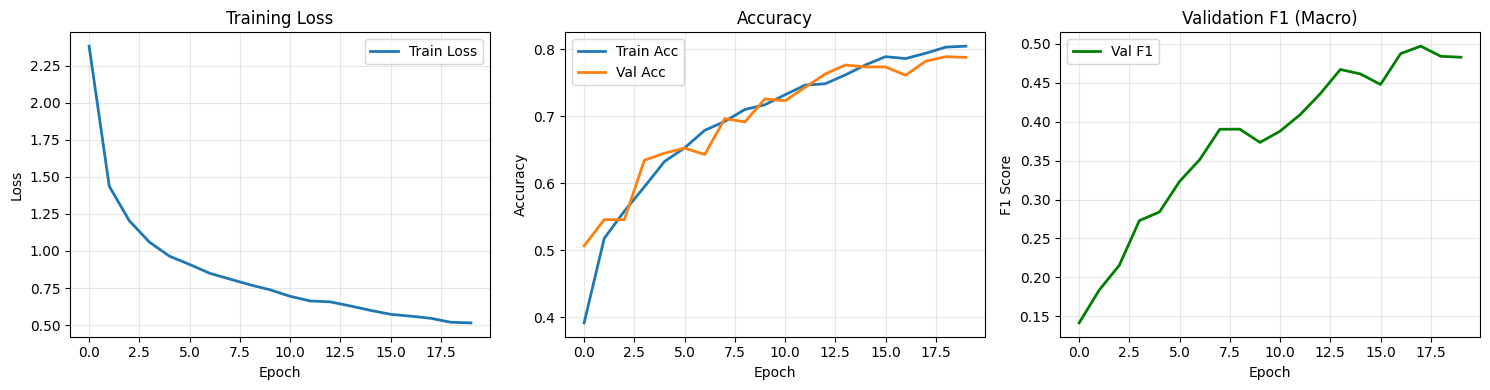

In [16]:
# PLOT TRAINING CURVES

plt.figure(figsize=(15, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train Acc", linewidth=2)
plt.plot(history["val_acc"], label="Val Acc", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(history["val_f1"], label="Val F1", linewidth=2, color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 (Macro)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(checkpoint_dir, "training_curves.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\n Saved training curves to {plot_path}")
plt.show()




In [17]:
# FINAL EVALUATION ON TEST SET

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Load best model
checkpoint = torch.load(os.path.join(checkpoint_dir, "best_cnn_lstm_enhanced.pth"))
model.load_state_dict(checkpoint["model_state"])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate
test_acc, test_f1, test_open_f1, test_closed_f1 = evaluate(model, test_loader, device)

print(f"\n Test Results:")
print(f"  Accuracy        : {test_acc:.4f}")
print(f"  All F1          : {test_f1:.4f}")
print(f"  Open-ended F1   : {test_open_f1:.4f}")
print(f"  Closed-ended F1 : {test_closed_f1:.4f}")


TEST SET EVALUATION
Loaded best model from epoch 19

 Test Results:
  Accuracy        : 0.7592
  All F1          : 0.4024
  Open-ended F1   : 0.4021
  Closed-ended F1 : 0.5603



SAMPLE PREDICTIONS

Sample 1:
  Question: What modality is used to take this image?
  Predicted: CT
  Ground Truth: CT


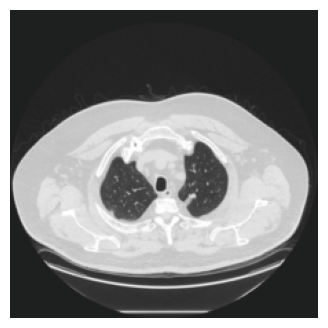


Sample 2:
  Question: Which part of the body does this image belong to?
  Predicted: Chest
  Ground Truth: Chest


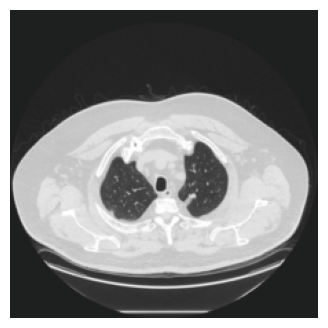


Sample 3:
  Question: What is the largest organ in the picture?
  Predicted: Lung
  Ground Truth: Lung


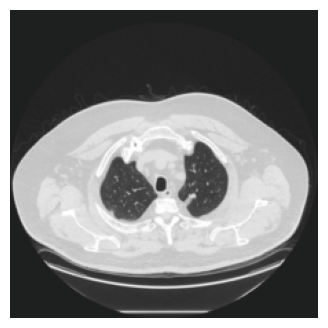


Sample 4:
  Question: Does the picture contain liver?
  Predicted: No
  Ground Truth: No


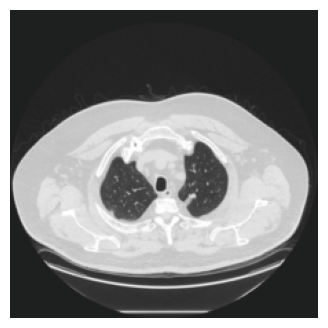


Sample 5:
  Question: Does the picture contain lung?
  Predicted: Yes
  Ground Truth: Yes


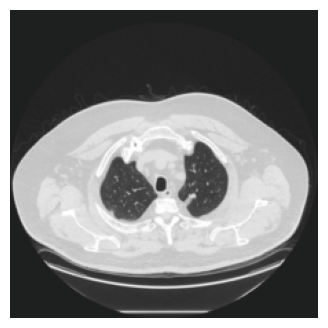

In [18]:
# VISUALIZE PREDICTIONS

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

model.eval()
with torch.no_grad():
    images, questions, answers, question_texts, answer_types = next(iter(test_loader))
    images_gpu = images.to(device)
    questions_gpu = questions.to(device)

    outputs = model(images_gpu, questions_gpu)
    preds = torch.argmax(outputs, dim=1)

images = images.cpu()
preds = preds.cpu()

print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

for i in range(min(5, len(images))):
    plt.figure(figsize=(4, 4))
    plt.imshow(unnormalize(images[i]))
    plt.axis("off")

    pred_ans = index_to_answer[preds[i].item()]
    true_ans = index_to_answer[answers[i].item()]

    print(f"\nSample {i+1}:")
    print(f"  Question: {question_texts[i]}")
    #print(f"  Type: {answer_types[i]}")
    print(f"  Predicted: {pred_ans}")
    print(f"  Ground Truth: {true_ans}")
    #print(f"  {' Correct' if pred_ans == true_ans else ' Wrong'}")

    plt.show()